In [1]:
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
import matplotlib
from matplotlib import pyplot as plt
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 14
# matplotlib.rcParams.update({'font.size': 20})
%matplotlib inline

In [2]:
# Here we set some parameters of the model:
params = (3,12,2,2,2,2,2,10,2) # N=3,Tmax=12,t_idle=2,t_bo=2,t_rts=2,t_out=2,t_cts=2,t_data=10,t_ack=2
collision_probabilities = np.linspace(0,0.9999,20)

In [3]:
def analytical_session_time(p_a,p,pf,params=params):
    N,Tmax,t_idle,t_bo,t_rts,t_out,t_cts,t_data,t_ack = params
    t_wait = t_data + t_ack
    
    # WE USE THE ANALYTICAL FORMULAS, WE GOT ABOVE IN THE PAPER
    D_data = t_data*p_a *(1-np.power(p,N+1))
    D_cts = t_cts*p_a *(1-np.power(p,N+1))
    D_ack = t_ack*p_a *(1-np.power(p,N+1))
    
    D_rts = t_rts*p_a *(1-np.power(p,N+1))/(1-p)
    D_out = t_out*p_a*p*(1-np.power(p,N+1))/(1-p)
    
    prob_bo,prob_wait = 0,0
    for k in range(1,N+2):
        prob_bo += np.power(p,k-1)*(1 + 1/(k*Tmax))*((k*Tmax+1)/(1 - np.power(pf,k*Tmax+1)) - 1/(1-pf)) 
        #prob_wait += np.power(p,k-1)*(1 + 1/(k*Tmax))*(((1-pf)*(k*Tmax+1))/(1 - np.power(pf,k*Tmax+1)) - 1)
        
    # не нужно посчитать prob_wait в цикле, она связана с prob_bo отношением ниже
    prob_wait = (1-pf)*prob_bo
    
    D_bo = t_bo*p_a*prob_bo
    D_wait = t_wait*p_a*prob_wait
    
    session_time = t_idle + D_cts + D_data + D_ack + D_rts + D_out + D_bo + D_wait
    
    return session_time

In [4]:
def simulated_session_time(p_a,p,pf,params=params):
    N,Tmax,t_idle,t_bo,t_rts,t_out,t_cts,t_data,t_ack = params
    t_wait = t_data + t_ack
    
    def ThereIsDataToSend(): # Checks if there is data to send (with probability p_a data will be found)
        return True if np.random.randint(0,100)  < np.round(100*p_a) else False

    def CollisionOccured():
        return True if np.random.randint(0,100)  < np.round(100*p) else False
    
    def ChannelIsFree():
        return True if np.random.randint(0,100)  < np.round(100*pf) else False

    session_time=0
    
    nth_attempt = 0 #Correspond to state idle
    
    session_time += t_idle
    
    if ThereIsDataToSend():
        nth_attempt = 1
        
        while nth_attempt <= N+1:
            state_back_off = np.random.randint(1,nth_attempt *Tmax+1) # Back off state
            # state_back_off = 0 ==> Txrts
            # state_back_off = -1 ==> wait
            
            while state_back_off != 0: #The loop stops as soon as state_back_off=0
                if state_back_off == -1:# состояние wait
                    session_time += t_wait
                    state_back_off = np.random.randint(0,nth_attempt *Tmax+1)
                else:
                    session_time += t_bo
                    if ChannelIsFree():
                        state_back_off -= 1
                    else:
                        state_back_off = -1
            
            # HERE THE NODE IS AT STATE TXrts
            session_time += t_rts
            
            if not CollisionOccured(): #Successful transmission
                session_time += t_cts + t_data + t_ack 
                break
            else:
                session_time += t_out
            nth_attempt += 1
    
    return session_time

In [5]:
pa_values = [0.25,0.5,1]
pf = 0.8
analytical = []
simulation = []
error = []

for p_a in pa_values:
    analytical_time = []
    simulation_time = []

    for p in collision_probabilities:
        analytical_time.append(analytical_session_time(p_a,p,pf))
        simulated_sessions_time = []
        for j in range(1_000_000):
            simulated_sessions_time.append(simulated_session_time(p_a,p,pf))
        simulation_time.append(np.mean(simulated_sessions_time))
    analytical.append(analytical_time)
    simulation.append(simulation_time)
    error.append(np.abs((np.asarray(analytical_time)-np.asarray(simulation_time))/np.asarray(analytical_time)))

np.save("analytical.npy",np.asarray(analytical))
np.save("simulation.npy",np.asarray(simulation))
np.save("error.npy",np.asarray(error))

Wall time: 3h 44min 22s


In [3]:
simulation_pa_025, simulation_pa_05, simulation_pa_1 = np.load("simulation.npy")
analytical_pa_025, analytical_pa_05, analytical_pa_1 = np.load("analytical.npy")
error_pa_025, error_pa_05, error_pa_1 = np.load("error.npy")

In [4]:
mre25,mre50,mre100 = round(error_pa_025.max(),4),round(error_pa_05.max(),4),round(error_pa_1.max(),4)

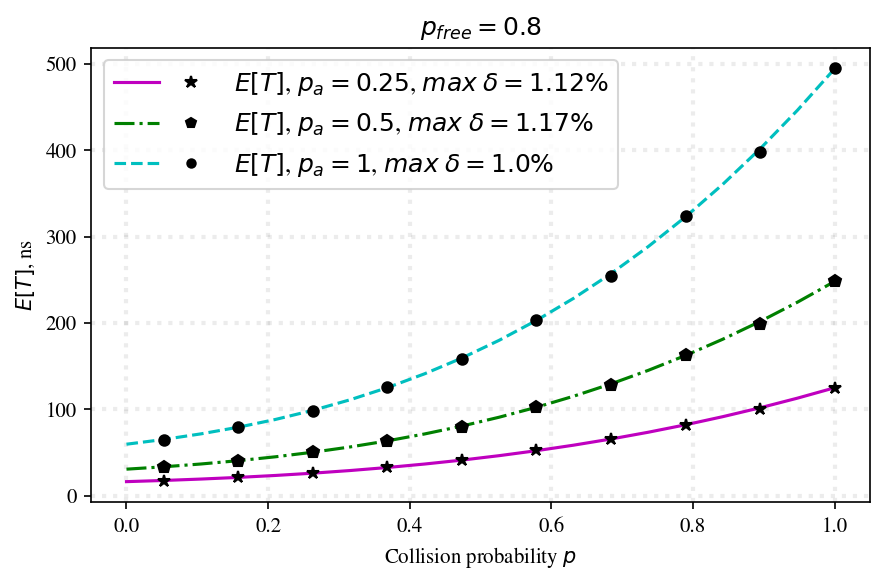

In [6]:
fig = plt.figure(dpi=150)
ax0 = plt.subplot2grid((1, 1), (0, 0))

ax0.plot(collision_probabilities, analytical_pa_025, "m-", label="$D_{an}$, $p_a=0.25$")
ax0.plot(collision_probabilities[1::2], simulation_pa_025[1::2], "k*", markersize=6, label="$D_{sim}$, $p_a=0.25$")
ax0.plot(collision_probabilities, analytical_pa_05, "g-.", label="$D_{an}$, $p_a=0.5$")
ax0.plot(collision_probabilities[1::2], simulation_pa_05[1::2], "kp", markersize=6, label="$D_{sim}$, $p_a=0.5$")
ax0.plot(collision_probabilities, analytical_pa_1, "c--", label="$D_{an}$, $p_a=1$")
ax0.plot(collision_probabilities[1::2], simulation_pa_1[1::2], "ko", markersize=5, label="$D_{sim}$, $p_a=1$")

an1 = Line2D([0], [0], ls='-', color='m')
an2 = Line2D([0], [0], ls='-.', color='g')
an3 = Line2D([0], [0], ls='--', color='c')

si1 = Line2D([0], [0], lw=0, marker='*', markersize=6, color='black')
si2 = Line2D([0], [0], lw=0, marker='p', markersize=5, color='black')
si3 = Line2D([0], [0], lw=0, marker='o', markersize=4, color='black')

l = ax0.legend(
    [(an1, si1), (an2, si2), (an3, si3)], 
    [f'$E[T]$, $p_a=0.25$, $max$ $\delta=1.12\%$', f'$E[T]$, $p_a=0.5$, $max$ $\delta={100*mre50}\%$', f'$E[T]$, $p_a=1$, $max$ $\delta={100*mre100}\%$'], 
    handlelength=4,
    handler_map={tuple: HandlerTuple(ndivide=None)}, loc=2, prop={'size': 12})

ax0.set_xlabel("Collision probability $p$")
ax0.set_ylabel("$E[T]$, ns")
ax0.grid(b=True, color='gray', alpha=0.15, linestyle=':', linewidth=2)

plt.title("$p_{free} = 0.8$")
plt.tight_layout()
plt.savefig("csma_ca simulation results.png", dpi=600)
plt.show()

In [9]:
print(f"Max errors:\nFor p_a = 0.25: {error_pa_025.max()}\nFor p_a = 0.5: {error_pa_05.max()}\nFor p_a = 1: {error_pa_1.max()}\n")

Max errors:
For p_a = 0.25: 0.011195464329688376
For p_a = 0.5: 0.011715876617801985
For p_a = 1: 0.009985376230973458



0.0112